In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import ops
from geographiclib.geodesic import Geodesic

In [2]:
%load_ext sql
%sql postgresql://localhost:5432/gebco_2019
%sql create extension if not exists postgis
%sql

 * postgresql://localhost:5432/gebco_2019
Done.
 * postgresql://localhost:5432/gebco_2019


In [3]:
# plotting modules
import matplotlib.pyplot as plt
from matplotlib import cm, colors
%matplotlib inline

## Parameters

In [4]:
# Gaussian filter sigma, km
sigmakm = 10

## Raster from file

In [5]:
# regridded from GEBCO 2019
da = xr.open_dataarray('GEBCO_2019.15min.nc').squeeze(drop=True)
da

<xarray.DataArray 'elevation' (lat: 720, lon: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Attributes:
    long_name:           Elevation relative to sea level
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_uom_name:        Metres
    sdn_uom_urn:         SDN:P06::ULAA
    standard_name:       height_above_reference_ellipsoid
    units:               m

## Raster to Database

In [6]:
%%time
da.to_dataframe(name='z').to_csv('data.csv', header=False)

CPU times: user 2.99 s, sys: 156 ms, total: 3.15 s
Wall time: 3.29 s


In [7]:
fname = !pwd
fname = fname[0] + '/data.csv'

In [8]:
%%time
%%sql

create extension if not exists postgis;
drop table if exists data;
create table data (lat float, lon float, z float, the_geom geography(Point, 4326));
COPY data (lat, lon, z) FROM :fname WITH DELIMITER ',';
UPDATE data SET the_geom = ST_SetSRID(ST_MakePoint(lon, lat), 4326);
CREATE INDEX data_the_geom_idx ON data USING GIST (the_geom);
ANALYZE data;

 * postgresql://localhost:5432/gebco_2019
Done.
Done.
Done.
1036800 rows affected.
1036800 rows affected.
Done.
Done.
CPU times: user 13.7 ms, sys: 5.08 ms, total: 18.7 ms
Wall time: 17.8 s


[]

## Grid to Database

In [9]:
grid = da[::5,::5]
print (grid.shape[0]*grid.shape[1])
grid

41472


<xarray.DataArray 'elevation' (lat: 144, lon: 288)>
array([[ 2805.0588,  2804.8135,  2804.4014, ...,  2805.9727,  2805.638 ,
         2805.3767],
       [ 3120.1628,  3117.6592,  3115.037 , ...,  3126.8013,  3125.1523,
         3122.6858],
       [ 3054.899 ,  3042.1133,  3024.9888, ...,  3070.7793,  3068.293 ,
         3062.9836],
       ...,
       [-3893.368 , -3893.6182, -3875.7866, ..., -3910.155 , -3887.9255,
        -3882.544 ],
       [-3943.2969, -3914.2798, -3900.6562, ..., -3902.9524, -3913.2334,
        -3912.2932],
       [-1746.7501, -1701.1638, -1669.2222, ..., -2094.0159, -1961.6682,
        -1844.1531]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.88 -88.62 -87.38 -86.12 ... 86.38 87.62 88.88
  * lon      (lon) float64 -179.9 -178.6 -177.4 -176.1 ... 176.4 177.6 178.9
Attributes:
    long_name:           Elevation relative to sea level
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_uom_name:        Metres
    sdn_uom_urn:         SDN:P06::ULAA
    standard_name:       height_above_reference_ellipsoid
    units:               m

In [10]:
grid.to_dataframe(name='z0').to_csv('grid.csv', header=False)

In [11]:
fname = !pwd
fname = fname[0] + '/grid.csv'

In [12]:
%%time
%%sql

drop table if exists grid;
create table grid (lat float, lon float, z0 float, the_geom geography(Point, 4326));
COPY grid (lat, lon, z0) FROM :fname WITH DELIMITER ',';
UPDATE grid SET the_geom = ST_SetSRID(ST_MakePoint(lon, lat), 4326);
CREATE INDEX grid_the_geom_idx ON grid USING GIST (the_geom);
ANALYZE grid;

 * postgresql://localhost:5432/gebco_2019
Done.
Done.
41472 rows affected.
41472 rows affected.
Done.
Done.
CPU times: user 9.82 ms, sys: 3.93 ms, total: 13.8 ms
Wall time: 942 ms


[]

## Gaussian Filtering in Database

In [13]:
%%sql

DROP FUNCTION IF EXISTS gaussian_transform(sigma float, geom geography);
CREATE OR REPLACE FUNCTION gaussian_transform(sigma float, geom geography)
    RETURNS TABLE (z float, count bigint)
    AS '
with weights as (
    select
        z,
        exp(-(pow(ST_Distance($2,the_geom,false),2))/(2*pow($1,2))) as weight
    from data
    where ST_Buffer($2,4.*$1) && the_geom and ST_DWithin($2, the_geom, 4.*$1)
)
select
    sum(z*weight)/sum(weight) as z,
    count(1) as count
from weights
'
LANGUAGE SQL STABLE;

 * postgresql://localhost:5432/gebco_2019
Done.
Done.


[]

In [14]:
%%time

%sql drop table if exists gaussian_transform;
%sql create table gaussian_transform (lat float, lon float, z0 float, z float, count bigint);

%sql insert into gaussian_transform \
     select lat, lon, z0, t.* from grid, gaussian_transform(:sigmakm*1000, the_geom) as t;

 * postgresql://localhost:5432/gebco_2019
Done.
 * postgresql://localhost:5432/gebco_2019
Done.
 * postgresql://localhost:5432/gebco_2019
41472 rows affected.
CPU times: user 8.26 ms, sys: 2.59 ms, total: 10.8 ms
Wall time: 13.2 s


## Show Gaussian Transform map

In [15]:
%sql points << select * from gaussian_transform

 * postgresql://localhost:5432/gebco_2019
41472 rows affected.
Returning data to local variable points


In [16]:
points = points.DataFrame()

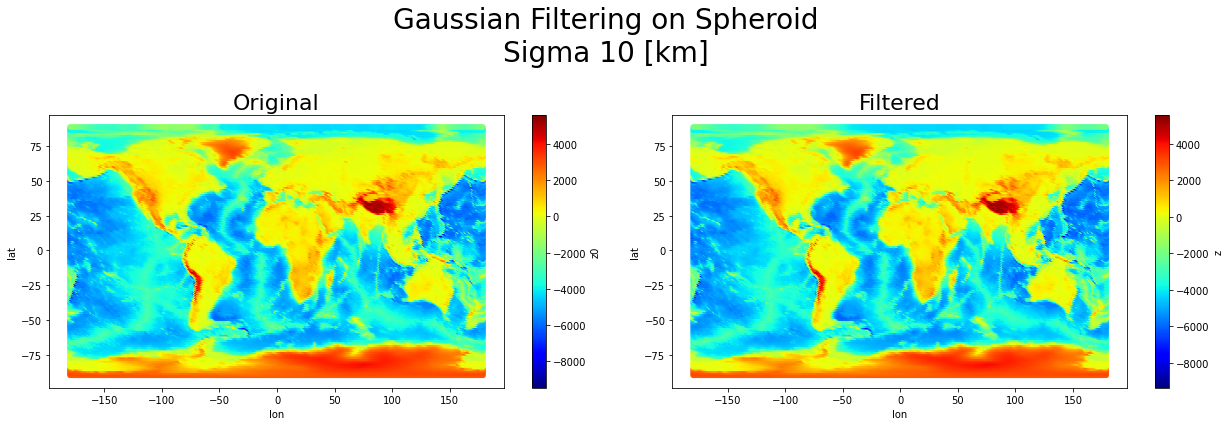

In [17]:
fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot(1, 2, 1)
points.plot('lon', 'lat', 'scatter',c='z0',cmap='jet', ax=ax)
ax.set_title('Original', fontsize=22)

ax = fig.add_subplot(1, 2, 2)
points.plot('lon', 'lat', 'scatter',c='z',cmap='jet', ax=ax)
ax.set_title('Filtered', fontsize=22)

plt.suptitle(f'Gaussian Filtering on Spheroid\nSigma {sigmakm} [km]', fontsize=28)
fig.tight_layout(rect=[0.03, 0.0, 1, 0.97])
#plt.savefig(f'Gaussian Filtering on Spheroid. Sigma {sigmakm} [km].jpg', dpi=150, pil_kwargs={'quality': 95})
plt.show()

In [18]:
# High-Pass Gravity
points['High-Pass Gravity'] = points.apply(lambda row: row['z']-row['z0'], axis=1)

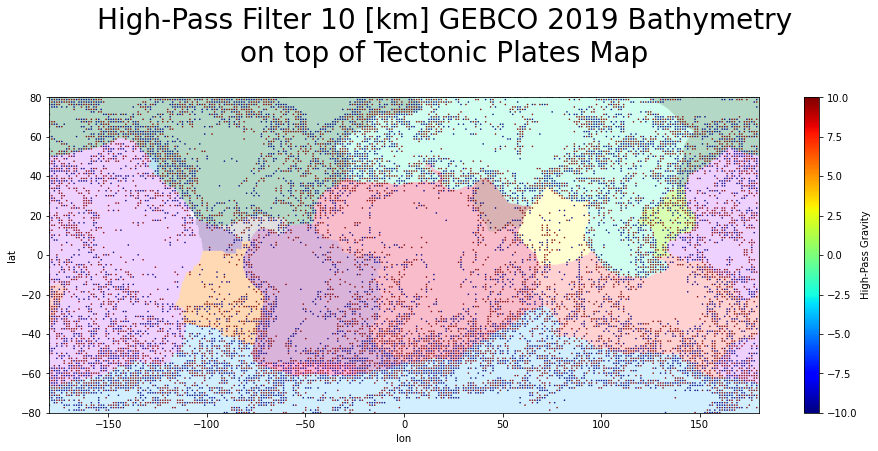

In [19]:
fig = plt.figure(figsize=(14,6))

#Tectonic Plates and Plate Boundaries (WMS)
#https://svs.gsfc.nasa.gov/2953
image = plt.imread('plates.png')

ax = fig.add_subplot(1, 1, 1)

ax.imshow(image[:,:,:3], interpolation='bilinear', extent=[-180,180,-90,90], alpha=.3)

points[abs(points['High-Pass Gravity'])>10].plot('lon', 'lat', 'scatter', c='High-Pass Gravity', s=.3, vmin=-10, vmax=10, cmap='jet', ax=ax)
#points.plot('lon', 'lat', 'scatter', c='dz', s=1, vmin=-40, vmax=40, cmap='jet', ax=ax)

ax.set_xlim([-180,180])
ax.set_ylim([-80,80])

plt.suptitle(f'High-Pass Filter {sigmakm} [km] GEBCO 2019 Bathymetry\non top of Tectonic Plates Map', fontsize=28)
fig.tight_layout(rect=[0.05, 0.0, 1, 0.97])
plt.savefig(f'Gaussian Filtering on Spheroid GEBCO 2019 Bathymetry. Sigma {sigmakm} [km] on Tectonic Plates Map.jpg', dpi=150, pil_kwargs={'quality': 95})
plt.show()

## Detect Lineaments

In [20]:
raster = points.set_index(['lat','lon']).to_xarray()['High-Pass Gravity']
raster = raster.astype(bool)\
    .where(abs(raster)>10)\
    .rename({'lat': 'y', 'lon': 'x'})\
    .fillna(0)

In [21]:
from skimage.transform import probabilistic_hough_line

lines = probabilistic_hough_line(raster.values, line_length=10, line_gap=5)

# for inverse geodetic calculation
geod = Geodesic.WGS84

geoms = []
attrs = []
for line in lines:
    p0, p1 = line
    #print ("line", line)

    xy0 = raster.isel(x=p0[0], y=p0[1])
    xy1 = raster.isel(x=p1[0], y=p1[1])
    # planar calculation
    #if xy1.x == xy0.x:
    #    radian = float(np.sign(xy1.y - xy0.y)*np.pi/2)
    #else:
    #    radian = np.atan((xy1.y - xy0.y)/(xy1.x - xy0.x))
    #degrees = radian * 180 / np.pi
    #print ("degrees", np.round(degrees))

    # geodetic calculation
    g = geod.Inverse(float(xy0.y), float(xy0.x), float(xy1.y), float(xy1.x))
    radian = np.pi*(90 + g['azi1'])/180
    radian = radian if radian<=np.pi else radian-2*np.pi
    length = g['s12']

    geom = ops.LineString([(xy0.x, xy0.y), (xy1.x, xy1.y)])
    attr = {'angle': radian, 'length': length}
    geoms.append(geom)
    attrs.append(attr)
    
    # symmetrize by adding inverse direction too
    attr = {'angle': radian-np.pi if radian >=0 else np.pi+radian, 'length': length}
    geoms.append(geom)
    attrs.append(attr)

df = gpd.GeoDataFrame(attrs,geometry=geoms).set_crs(4326)

In [22]:
df['length'].min(), df['length'].max()

(30080.955336126717, 17170872.13944785)

In [23]:
df['angle'].min(), df['angle'].max()

(-3.1400086238308083, 3.1400086238308083)

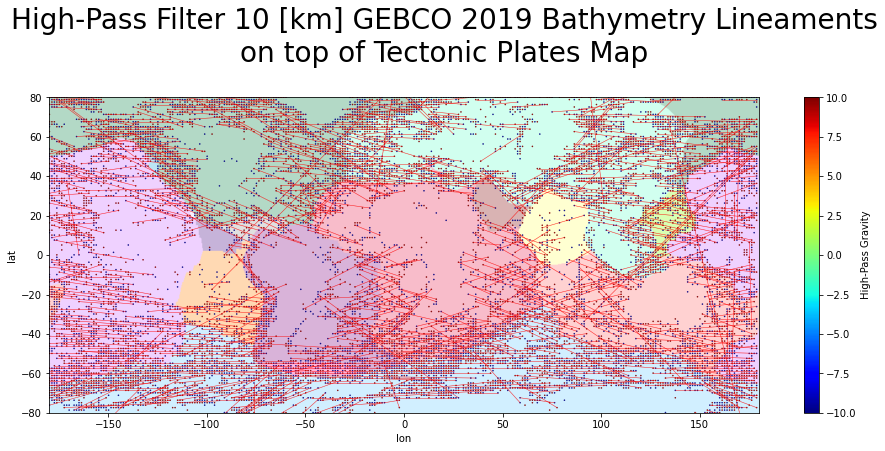

In [24]:
fig = plt.figure(figsize=(14,6))

#Tectonic Plates and Plate Boundaries (WMS)
#https://svs.gsfc.nasa.gov/2953
image = plt.imread('plates.png')

ax = fig.add_subplot(1, 1, 1)

ax.imshow(image[:,:,:3], interpolation='bilinear', extent=[-180,180,-90,90], alpha=.3)

points[abs(points['High-Pass Gravity'])>10].plot('lon', 'lat', 'scatter', c='High-Pass Gravity', s=.3, vmin=-10, vmax=10, cmap='jet', ax=ax)
df.plot(lw=0.5, alpha=0.5, color='red', ls='-', ax=ax)

ax.set_xlim([-180,180])
ax.set_ylim([-80,80])

plt.suptitle(f'High-Pass Filter {sigmakm} [km] GEBCO 2019 Bathymetry Lineaments\non top of Tectonic Plates Map', fontsize=28)
fig.tight_layout(rect=[0.05, 0.0, 1, 0.97])
plt.savefig(f'Gaussian Filtering Lineaments on Spheroid GEBCO 2019 Bathymetry. Sigma {sigmakm} [km] on Tectonic Plates Map.jpg', dpi=150, pil_kwargs={'quality': 95})
plt.show()

## Rose Diagram
https://matplotlib.org/1.2.1/examples/pylab_examples/polar_bar.html

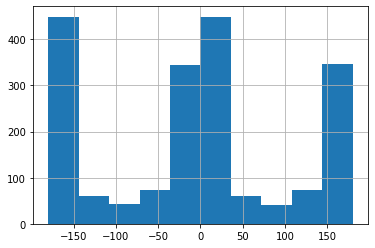

In [25]:
# make the same histogram plot as the rose diagram below
(180*df['angle']/np.pi).hist()
plt.show()

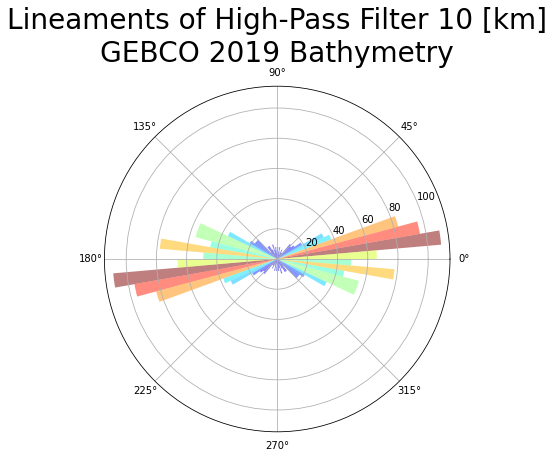

In [26]:
angles = np.linspace(-np.pi, np.pi, 2*36+1, endpoint=True)
labels = (angles[1:] + angles[:-1])/2
binned = pd.cut(df['angle'], bins=angles, labels=labels).value_counts()

# force square figure and square axes looks better for polar, IMO
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

theta = binned.index
radii = binned.values
width = np.diff(angles)[0]

bars = ax.bar(theta, radii, width=width, bottom=0.0)
for r,bar in zip(radii, bars):
    #bar.set_facecolor( cm.plasma_r(r/np.max(radii)))
    bar.set_facecolor( cm.jet(r/np.max(radii)))
    bar.set_alpha(0.5)

plt.title(f'Lineaments of High-Pass Filter {sigmakm} [km]\nGEBCO 2019 Bathymetry', fontsize=28)
plt.savefig(f'Lineaments of High-Pass Filter {sigmakm} [km] GEBCO 2019 Bathymetry.jpg', \
            bbox_inches='tight', dpi=150, pil_kwargs={'quality': 95})
plt.show()